# Planets Model

## Load Libs


In [1]:
import ast
import os
import re
from datetime import datetime as dt

import icecream
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as L
import torch
from icecream import ic
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import hephaestus as hp
from hephaestus.timeseries_models import tabular_collate_fn

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
# pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("MPS available")
else:
    print("CUDA not available. Checking why...")
    import os

    print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set')}")

PyTorch version: 2.6.0
CUDA available: False
MPS available


## Load Data

We use `line2df` to load the original data from
[PolyMathic](https://polymathic-ai.org/blog/xval/). Since we've already transformed the
data into a parquet file, we can load it directly.


In [3]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [4]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [5]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [6]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['2_planets',
 '5_planets',
 '3_planets',
 '4_planets',
 'increasing',
 'decreasing']

In [7]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [8]:
df = df.reset_index(drop=True)
# df = df.head(
#     5_000
# )  # For testing purposes only, train on the full dataset in production

In [9]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [10]:
time_series_config.n_columns

30

In [10]:
N_HEADS = 8 * 4
# tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)
tabular_decoder = hp.TabularDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [ ]:
logger_variant_name = "Plannets_Small"
logger_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
logger_name = f"{logger_time}_{logger_variant_name}"
print(f"Using logger name: {logger_name}")
logger = TensorBoardLogger(
    "runs",
    name=logger_name,
)
early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
trainer = L.Trainer(max_epochs=2, logger=logger, callbacks=[early_stopping])
train_dl = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
test_dl = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
trainer.fit(tabular_decoder, train_dl, test_dl)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TimeSeriesDecoder | 51.4 M | train
----------------------------------------------------
51.4 M    Trainable params
0         Non-trainable params
51.4 M    Total params
205.734   Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

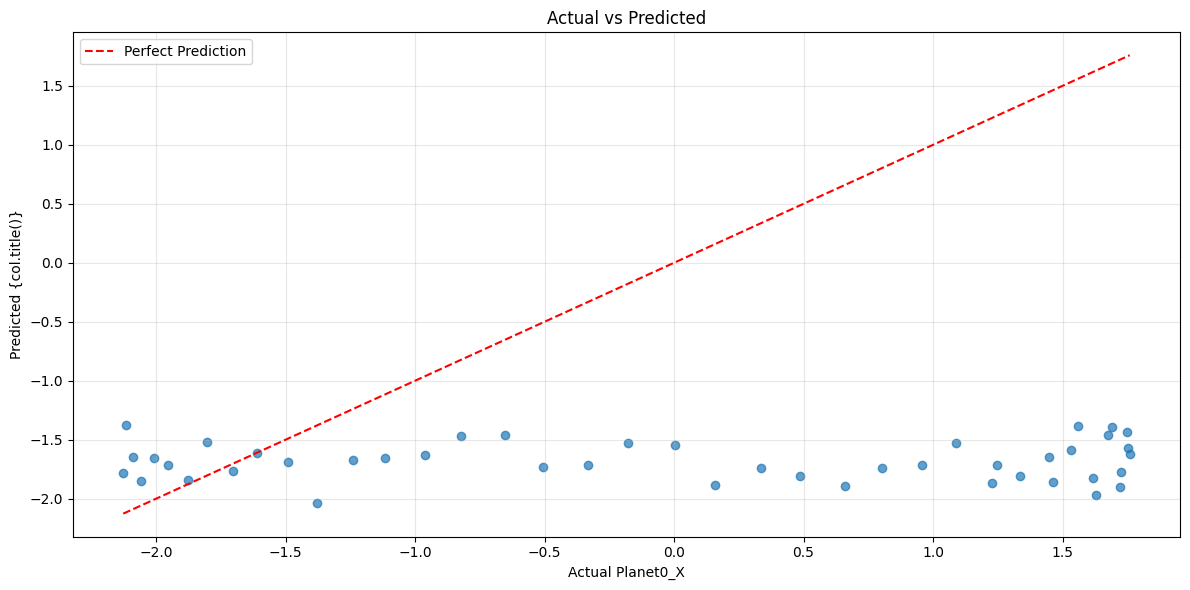

In [ ]:
hp.plot_col_error(df_comp, "planet0_x")

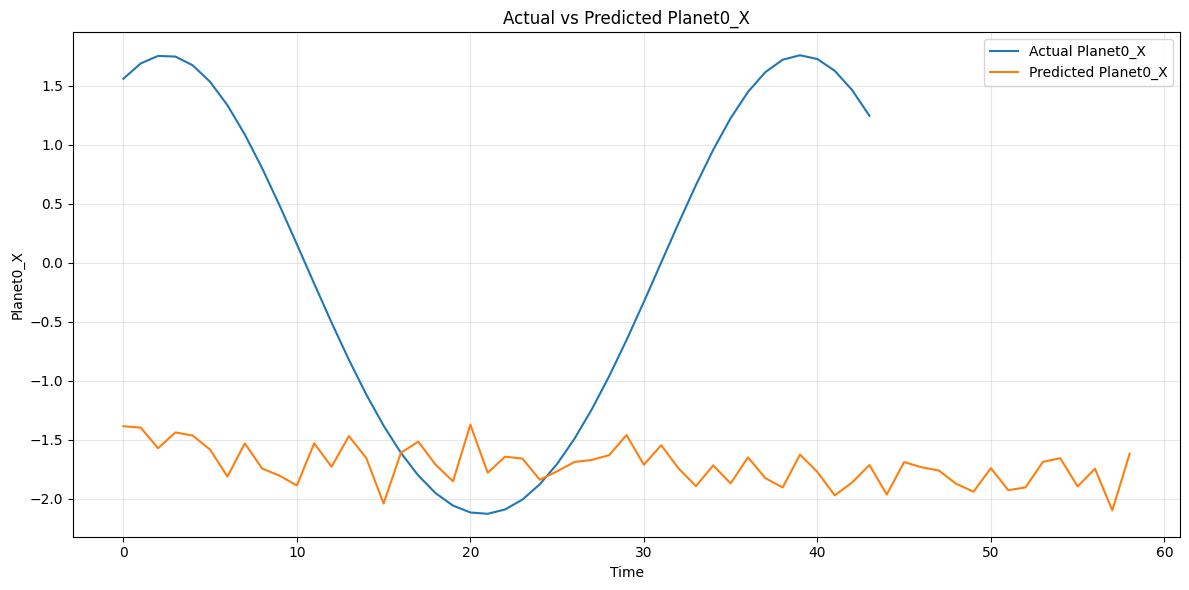

In [ ]:
hp.plot_col_comparison(df_comp, "planet0_x")

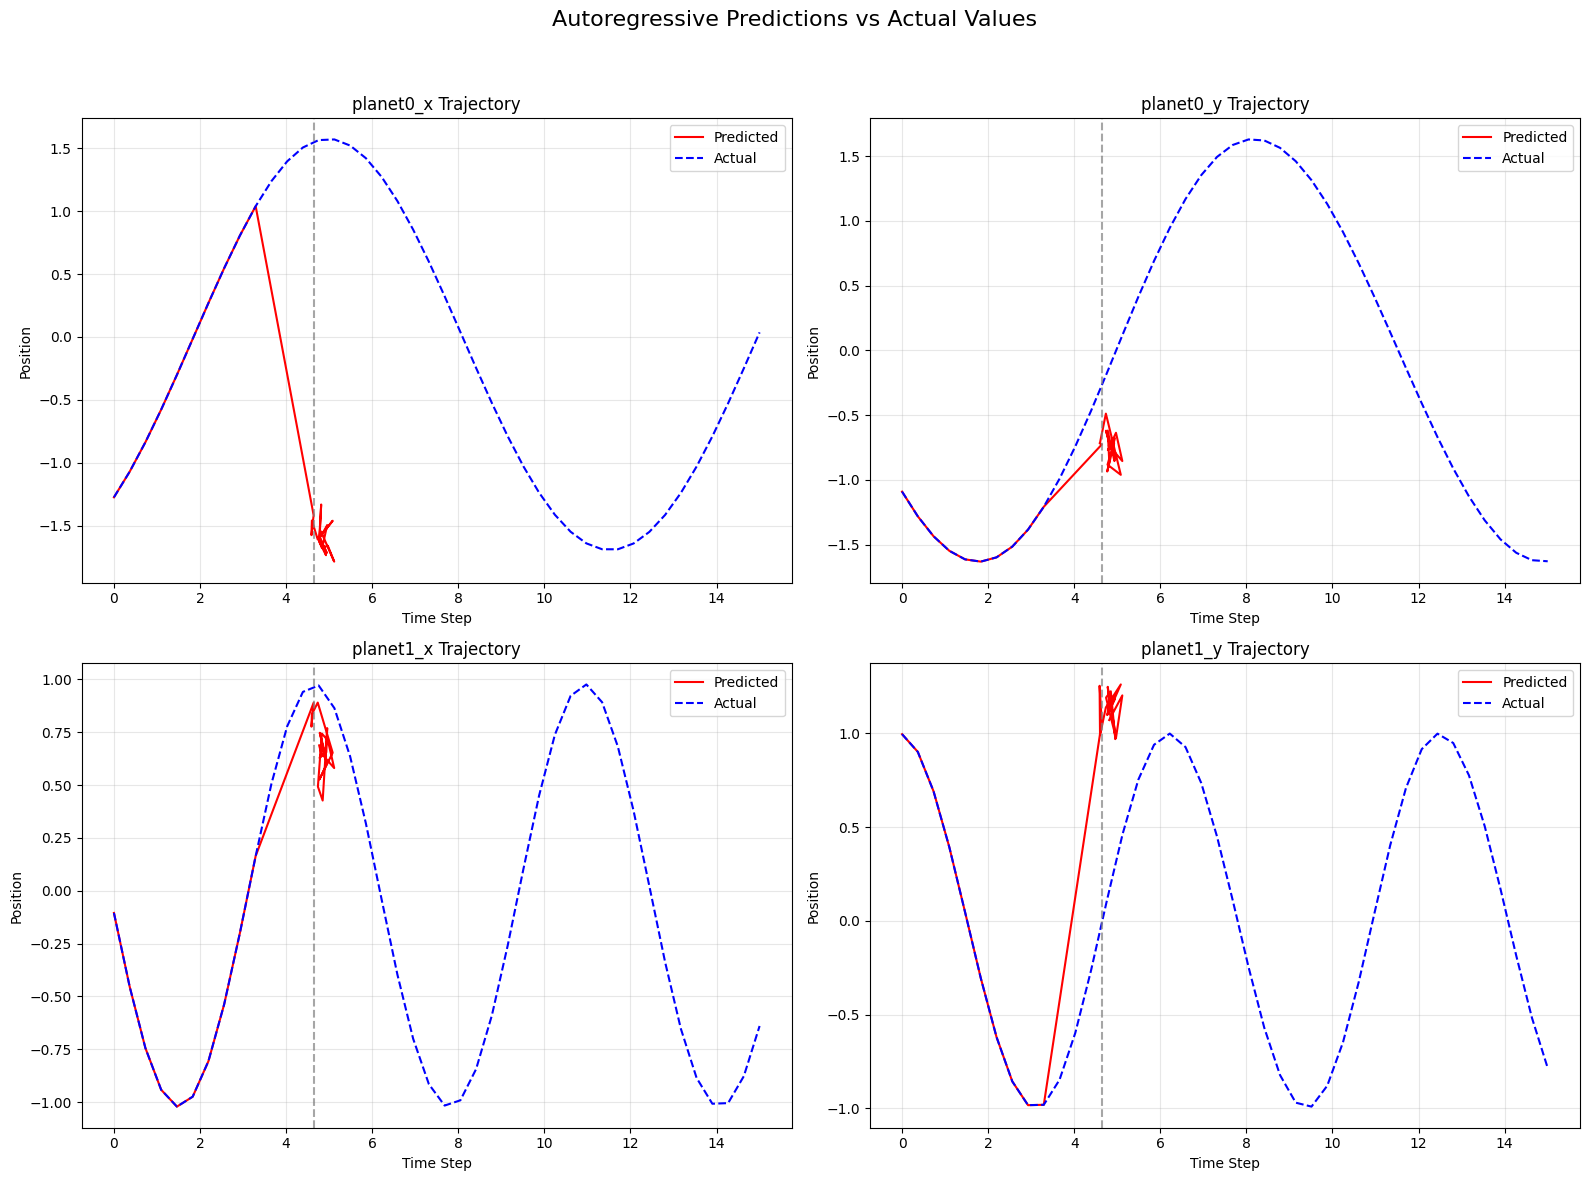

In [ ]:
# Create initial inputs from the test dataset
test_idx = 5  # Choose a test sample
stop_idx = 10  # Start predictions after this timestep
inputs = hp.AutoRegressiveResults.from_ds(test_ds, test_idx, stop_idx=stop_idx)

# Generate predictions for multiple steps
num_prediction_steps = 20
for _ in range(num_prediction_steps):
    inputs = hp.auto_regressive_predictions(tabular_decoder, inputs)

# Process the results into DataFrames for analysis
actual_inputs = test_ds[test_idx]
actual_df = hp.create_test_inputs_df(
    hp.AutoRegressiveResults(actual_inputs.numeric, actual_inputs.categorical),
    time_series_config,
)
predicted_df = hp.create_test_inputs_df(inputs, time_series_config)

# Plot comparisons for several key columns
# Create a 2x2 grid of plots for different planet positions
plt.figure(figsize=(16, 12))
columns_to_plot = ["planet0_x", "planet0_y", "planet1_x", "planet1_y"]

for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i + 1)

    # Only plot from stop_idx onward
    ax = plt.gca()
    ax.plot(
        predicted_df["time_step"],
        predicted_df[col],
        "r-",
        label="Predicted",
    )
    ax.plot(
        actual_df["time_step"],
        actual_df[col],
        "b--",
        label="Actual",
    )

    # Add vertical line to mark prediction start
    ax.axvline(
        x=predicted_df["time_step"][stop_idx], color="gray", linestyle="--", alpha=0.7
    )

    # Add annotations
    ax.set_title(f"{col} Trajectory")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Autoregressive Predictions vs Actual Values", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
plt.show()